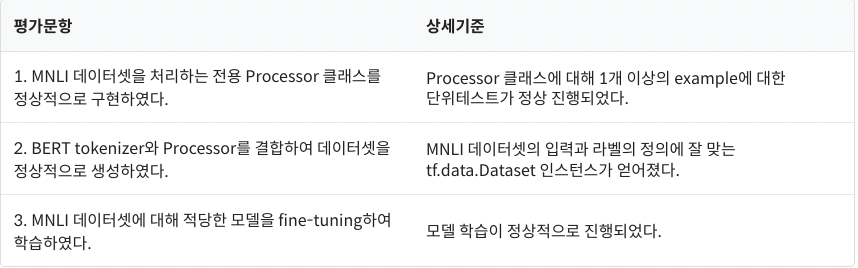

## HugglingFace Fintunning 하기

In [1]:
# !pip install tensorflow-datasets -U

In [2]:
import tensorflow
import numpy
import transformers
import argparse

import os
import numpy as np
from argparse import ArgumentParser
import tensorflow as tf
import tensorflow_datasets as tfds
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, AutoConfig
from dataclasses import asdict
from transformers.data.processors.utils import DataProcessor, InputExample, InputFeatures
import datasets
from datasets import load_dataset

In [3]:
'''
 Multi-Genre Natural Language Inference Corpus는 텍스트 수반 주석이 있는 문장 쌍의 크라우드 소싱 모음입니다. 
 전제 문장과 가설 문장이 주어졌을 때, 과제는 전제가 가설을 수반하는지(entailment), 가설과 모순되는지(모순), 
 아니면 둘 다 그렇지 않은지(중립) 예측하는 것입니다. 전제 문장은 전사된 연설, 소설 및 정부 보고서를 포함하여 10가지 다른 출처에서 수집됩니다.
 우리는 저자로부터 개인 레이블을 얻은 표준 테스트 세트를 사용하고 일치(도메인 내) 섹션과 일치하지 않는(교차 도메인) 섹션 모두에서 평가합니다.
 또한 SNLI 코퍼스를 보조 훈련 데이터의 550k 예시로 사용하고 권장합니다.
 '''

data, info = tfds.load('glue/mnli', with_info=True)
info.splits['train'].num_examples

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: glue/mnli/2.0.0
INFO:absl:Load dataset info from /tmp/tmpam8sgmvitfds
INFO:absl:Generating dataset glue (/aiffel/tensorflow_datasets/glue/mnli/2.0.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://dl.fbaipublicfiles.com/glue/data/MNLI.zip into /aiffel/tensorflow_datasets/downloads/dl.fbaipublicfiles.com_glue_MNLIdNe8cK2kTBCG0bqBz2JxwShRT2KfuO3NVIwROTnjtfI.zip.tmp.34ebf659dba94f3489e9293be8722e69...


Generating splits...:   0%|          | 0/5 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/392702 [00:00<?, ? examples/s]

Shuffling glue-train.tfrecord...:   0%|          | 0/392702 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-train.tfrecord. Number of examples: 392702 (shards: [392702])


Generating validation_matched examples...:   0%|          | 0/9815 [00:00<?, ? examples/s]

Shuffling glue-validation_matched.tfrecord...:   0%|          | 0/9815 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-validation_matched.tfrecord. Number of examples: 9815 (shards: [9815])


Generating validation_mismatched examples...:   0%|          | 0/9832 [00:00<?, ? examples/s]

Shuffling glue-validation_mismatched.tfrecord...:   0%|          | 0/9832 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-validation_mismatched.tfrecord. Number of examples: 9832 (shards: [9832])


Generating test_matched examples...:   0%|          | 0/9796 [00:00<?, ? examples/s]

Shuffling glue-test_matched.tfrecord...:   0%|          | 0/9796 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-test_matched.tfrecord. Number of examples: 9796 (shards: [9796])


Generating test_mismatched examples...:   0%|          | 0/9847 [00:00<?, ? examples/s]

Shuffling glue-test_mismatched.tfrecord...:   0%|          | 0/9847 [00:00<?, ? examples/s]

INFO:absl:Done writing glue-test_mismatched.tfrecord. Number of examples: 9847 (shards: [9847])
INFO:absl:Constructing tf.data.Dataset glue for split None, from /aiffel/tensorflow_datasets/glue/mnli/2.0.0


Dataset glue downloaded and prepared to /aiffel/tensorflow_datasets/glue/mnli/2.0.0. Subsequent calls will reuse this data.


392702

In [4]:
data['train'].take(1)

<TakeDataset shapes: {hypothesis: (), idx: (), label: (), premise: ()}, types: {hypothesis: tf.string, idx: tf.int32, label: tf.int64, premise: tf.string}>

In [5]:
examples = data['train'].take(1)
for example in examples:
    hypothesis = example['hypothesis'] #가설
    idx = example['idx']
    label = example['label']
    premise = example['premise'] #전제
    print(hypothesis)
    print(idx)
    print(label)
    print(premise)

tf.Tensor(b'Meaningful partnerships with stakeholders is crucial.', shape=(), dtype=string)
tf.Tensor(16399, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', shape=(), dtype=string)


In [6]:
lab = []
for i in data['train']:
    label = i['label']
    if label not in lab:
        lab.append(label)

lab

[<tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>]

In [41]:
#허깅페이스로 데이터 받는법 
huggingface_mnli_dataset = load_dataset('glue', 'mnli')
print(huggingface_mnli_dataset)

Downloading:   0%|          | 0.00/7.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/313M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset glue downloaded and prepared to /aiffel/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/5 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


### MNLIProcessor class 구현

In [8]:
class DataProcessor:
    """Base class for data converters for sequence classification data sets."""

    def get_example_from_tensor_dict(self, tensor_dict):
        """
        Gets an example from a dict with tensorflow tensors.

        Args:
            tensor_dict: Keys and values should match the corresponding Glue
                tensorflow_dataset examples.
        """
        raise NotImplementedError()

    def get_train_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the dev set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of :class:`InputExample` for the test set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    def tfds_map(self, example):
        """
        Some tensorflow_datasets datasets are not formatted the same way the GLUE datasets are. This method converts
        examples to the correct format.
        """
        if len(self.get_labels()) > 1:
            example.label = self.get_labels()[int(example.label)]
        return example

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            return list(csv.reader(f, delimiter="\t", quotechar=quotechar))

In [9]:
class MnliProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def get_example_from_tensor_dict(self, tensor_dict):
        """See base class."""
        return InputExample(
            tensor_dict["idx"].numpy(),
            tensor_dict["hypothesis"].numpy().decode("utf-8"),
            tensor_dict["premise"].numpy().decode("utf-8"),
            str(tensor_dict["label"].numpy()),
        )

    def get_train_examples(self, data_dir):
        """See base class."""
        print("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

    def get_labels(self):
        """See base class."""
        return ["0", "1","2"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training, dev and test sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = None if set_type == "test" else line[0]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

In [10]:
processor = MnliProcessor()
examples = data['train'].take(1)

for example in examples:
    print('------원본데이터------')
    print(example)  
    example = processor.get_example_from_tensor_dict(example)
    print('------processor 가공데이터------')
    print(example)

------원본데이터------
{'hypothesis': <tf.Tensor: shape=(), dtype=string, numpy=b'Meaningful partnerships with stakeholders is crucial.'>, 'idx': <tf.Tensor: shape=(), dtype=int32, numpy=16399>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'premise': <tf.Tensor: shape=(), dtype=string, numpy=b'In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.'>}
------processor 가공데이터------
InputExample(guid=16399, text_a='Meaningful partnerships with stakeholders is crucial.', text_b='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal

In [11]:
examples = (data['train'].take(1))
for example in examples:
    example = processor.get_example_from_tensor_dict(example)
    example = processor.tfds_map(example)
    print(example)

InputExample(guid=16399, text_a='Meaningful partnerships with stakeholders is crucial.', text_b='In recognition of these tensions, LSC has worked diligently since 1995 to convey the expectations of the State Planning Initiative and to establish meaningful partnerships with stakeholders aimed at fostering a new symbiosis between the federal provider and recipients of legal services funding.', label='1')


In [12]:
label_list = processor.get_labels()
label_list

['0', '1', '2']

In [13]:
label_map = {label: i for i, label in enumerate(label_list)}
label_map

{'0': 0, '1': 1, '2': 2}

In [32]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels = 3)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_59', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

### Tokenizer, 데이터 구성

In [19]:
def _glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None,
                                       output_mode="claasification") :
    if max_length is None :
        max_length = tokenizer.max_len
    if label_list is None:
        label_list = processor.get_labels()
        print("Using label list %s" % (label_list))

    label_map = {label: i for i, label in enumerate(label_list)}
    labels = [label_map[example.label] for example in examples]

    batch_encoding = tokenizer(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}

        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)

    for i, example in enumerate(examples[:5]):
        print("*** Example ***")
        print("guid: %s" % (example.guid))
        print("features: %s" % features[i])

    return features

In [20]:
def tf_glue_convert_examples_to_features(examples, tokenizer, max_length, processor, label_list=None,
                                         output_mode="classification") :
    """
    :param examples: tf.data.Dataset
    :param tokenizer: pretrained tokenizer
    :param max_length: example의 최대 길이(기본값 : tokenizer의 max_len)
    :param task: GLUE task 이름
    :param label_list: 라벨 리스트
    :param output_mode: "regression" or "classification"

    :return: task에 맞도록 feature가 구성된 tf.data.Dataset
    """
    examples = [processor.tfds_map(processor.get_example_from_tensor_dict(example)) for example in examples]
    features = _glue_convert_examples_to_features(examples, tokenizer, max_length, processor)
    label_type = tf.int64

    def gen():
        for ex in features:
            d = {k: v for k, v in asdict(ex).items() if v is not None}
            label = d.pop("label")
            yield (d, label)

    input_names = ["input_ids"] + tokenizer.model_input_names

    return tf.data.Dataset.from_generator(
        gen,
        ({k: tf.int32 for k in input_names}, label_type),
        ({k: tf.TensorShape([None]) for k in input_names}, tf.TensorShape([])),
    )

In [21]:
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 15902, 13797, 2007, 22859, 2003, 10232, 1012, 102, 1999, 5038, 1997, 2122, 13136, 1010, 1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, 10908, 1997, 1996, 2110, 4041, 6349, 1998, 2000, 5323, 15902, 13797, 2007, 22859, 6461, 2012, 6469, 2075, 1037, 2047, 25353, 14905, 10735, 2483, 2090, 1996, 2976, 10802, 1998, 15991, 1997, 3423, 2578, 4804, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [22]:
examples = train_dataset.take(1)
for example in examples:
    print(example)

({'input_ids': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([  101, 15902, 13797,  2007, 22859,  2003, 10232,  1012,   102,
        1999,  5038,  1997,  2122, 13136,  1010,  1048, 11020,  2038,
        2499, 29454, 29206, 14626,  2144,  2786,  2000, 16636,  1996,
       10908,  1997,  1996,  2110,  4041,  6349,  1998,  2000,  5323,
       15902, 13797,  2007, 22859,  6461,  2012,  6469,  2075,  1037,
        2047, 25353, 14905, 10735,  2483,  2090,  1996,  2976, 10802,
        1998, 15991,  1997,  3423,  2578,  4804,  1012,   102,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,  

In [23]:
# train 데이터셋
train_dataset = tf_glue_convert_examples_to_features(data['train'], tokenizer, max_length=128, processor=processor)
train_dataset_batch = train_dataset.shuffle(100).batch(16).repeat(2)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 16399
features: InputFeatures(input_ids=[101, 15902, 13797, 2007, 22859, 2003, 10232, 1012, 102, 1999, 5038, 1997, 2122, 13136, 1010, 1048, 11020, 2038, 2499, 29454, 29206, 14626, 2144, 2786, 2000, 16636, 1996, 10908, 1997, 1996, 2110, 4041, 6349, 1998, 2000, 5323, 15902, 13797, 2007, 22859, 6461, 2012, 6469, 2075, 1037, 2047, 25353, 14905, 10735, 2483, 2090, 1996, 2976, 10802, 1998, 15991, 1997, 3423, 2578, 4804, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [24]:
# validation 데이터셋
validation_dataset = tf_glue_convert_examples_to_features(data['validation_matched'],
                                                          tokenizer, max_length=128, processor=processor)
validation_dataset_batch = validation_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 6287
features: InputFeatures(input_ids=[101, 3398, 7167, 1997, 2111, 2005, 1996, 2157, 2166, 102, 7910, 1011, 9616, 2821, 3398, 2035, 1996, 2111, 2005, 2157, 7910, 2166, 2030, 2242, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=0)
*** Example ***
guid: 1579
features: InputFeatures

In [25]:
# test 데이터셋
test_dataset = tf_glue_convert_examples_to_features(data['test_matched'],
                                                    tokenizer, max_length=128, processor=processor)
test_dataset_batch = test_dataset.shuffle(100).batch(16)

Using label list ['0', '1', '2']


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

*** Example ***
guid: 5398
features: InputFeatures(input_ids=[101, 2003, 2045, 1037, 10216, 2008, 2017, 2404, 1999, 2045, 1029, 102, 2092, 2003, 2045, 1037, 2210, 3751, 10216, 2017, 2404, 1999, 2045, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=None, label=2)
*** Example ***
guid: 1921
features: InputFeatures(

### 모델 구성 및 학습

In [33]:
num_classes = len(processor.get_labels())

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [34]:
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  2307      
_________________________________________________________________
dropout_59 (Dropout)         multiple                  0         
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 이전 스텝에서 배치처리를 진행한 데이터셋(xxxx_dataset_batch)을 활용
model.fit(train_dataset_batch, epochs=10, steps_per_epoch=115, 
                validation_data=validation_dataset_batch)

Epoch 1/10
115/115 [==============================] - 80s 640ms/step - loss: 1.0688 - acc: 0.4147 - val_loss: 1.0006 - val_acc: 0.5026
Epoch 2/10
115/115 [==============================] - 72s 626ms/step - loss: 0.9591 - acc: 0.5326 - val_loss: 0.9486 - val_acc: 0.5502
Epoch 3/10
115/115 [==============================] - 71s 624ms/step - loss: 0.8800 - acc: 0.6103 - val_loss: 0.8373 - val_acc: 0.6339
Epoch 4/10
115/115 [==============================] - 72s 627ms/step - loss: 0.8484 - acc: 0.6207 - val_loss: 0.8030 - val_acc: 0.6456
Epoch 5/10
115/115 [==============================] - 72s 626ms/step - loss: 0.8155 - acc: 0.6326 - val_loss: 0.7822 - val_acc: 0.6529
Epoch 6/10
115/115 [==============================] - 72s 626ms/step - loss: 0.8211 - acc: 0.6353 - val_loss: 0.7596 - val_acc: 0.6700
Epoch 7/10
115/115 [==============================] - 71s 625ms/step - loss: 0.7793 - acc: 0.6707 - val_loss: 0.7512 - val_acc: 0.6764
Epoch 8/10
115/115 [==============================] - 7

In [36]:
result = model.evaluate(test_dataset_batch)
print(result)

613/613 [==============================] - 48s 78ms/step - loss: 1.5724 - acc: 0.2921
[1.5723896026611328, 0.29205799102783203]


In [37]:
output_dir = os.getenv('HOME')+'/aiffel/transformers'
output_eval_file = os.path.join(output_dir, "eval_results.txt")

with open(output_eval_file, "w") as writer:
    for i, v in enumerate(result) :
        if i == 0 :
            writer.write("Loss = %f\t" %(v))
        if i == 1 :
            writer.write("Accuracy = %f\n" %(v))
print("완료=3")

#파일에 쓴 테스트 결과 확인
!cat ~/aiffel/transformers/eval_results.txt

완료=3
Loss = 1.572390	Accuracy = 0.292058


## 회고록
- loss nan 오류
클래스 내에서 get_label 부분을 수정해서 실행했음에도 로스가 제대로 책정되지않는 학습과정을 보여주었다. 이후 구글링을 통해서 model의 num_labels를 Task에 맞게 정해줬어야했음을 알게되었다.
- val_acc 와 test_acc의 큰 차이
3에폭 10에폭읉 통해서 학습을 진행했을 때 train,validation set에서는 매끄럽게 학습이 진행되었으나, test set에서는 여전히 크게 차이나는 정확도를 보여주었다.